Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [783]:
from random import random, seed
from itertools import product
import numpy as np
import timeit
from typing import Tuple
from icecream import ic
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from itertools import accumulate
from itertools import compress

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [784]:
UNIVERSE_SIZE = 100
NUM_SETS = 10

DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [785]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)


In [786]:
mincost=min(COSTS)

## Helper Functions

In [787]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def valid2(solution):
    """Checks whether solution is valid (i.e., covers all universe)"""
    # Logical OR over selected sets
    covered_universe = np.zeros(SETS.shape[1], dtype=bool)
    
    for i in np.where(solution)[0]:  # Only loop through 'True' solutions
        covered_universe |= SETS[i]
        # Exit early if the universe is fully covered
        if np.all(covered_universe):
            return True
    
    # Check if universe is fully covered at the end
    return np.all(covered_universe)

def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()



In [788]:
len(SETS)

10

## Have Fun!

In [789]:
# A dumb solution of "all" sets
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)

t1 = timeit.timeit(lambda: cost(solution), number=100)
ic(t1)


ic| t1: 0.00010799800020322436


0.00010799800020322436

In [790]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
ic(solution,len(solution))
valid(solution), cost(solution)

ic| solution: array([False, False,  True, False, False,  True,  True, False,  True,
                      True])
    len(solution): 10


(np.False_, np.float64(162.2701783601479))

In [791]:
def fitness(solution : np.array)-> int:
    costo=-cost(solution)
    #if valid2(solution):
       
       #costo=costo+50000
        #ic(pos)
        
    
    return costo

def fitness2(solution : np.array)-> Tuple[bool,int]:
    costo=-cost(solution)
    #costo=-(len(np.where(solution == True)[0]) *100)
    validity=False
    if valid2(solution):
       
       
       validity=True
        #ic(pos)
        
    
    return (validity,costo)

In [792]:



def tweak(solution : np.array)-> np.array:
    new_solution = solution.copy()
    pos = rng.integers(0,NUM_SETS)
    
    
    new_solution[pos] = not new_solution[pos]
    return new_solution

In [793]:
def tweak2(solution : np.array)-> np.array:   #non funziona
    n_tweaks=5
    new_solution = solution.copy()
    pos = rng.integers(0,NUM_SETS)
    current_solution=solution.copy()
    current_fit=fitness(solution)
    

    for step in range(n_tweaks):
        new_solution[pos] = not new_solution[pos]
        sol_fit=fitness(solution)
       
        if sol_fit>current_fit:
            current_solution = new_solution[:]
            current_fit=sol_fit
        
        new_solution[pos] = not new_solution[pos]
    
    
    
    return current_solution

In [794]:
def tweak3(solution : np.array,step: int,max_step :int)-> np.array:
    #size_change=1
    #size_change=1+(2*(max_step -step))//max_step
    #size_change=1+((max_step -step))//max_step
    size_change=(20*(max_step -step))//max_step
    
    new_solution = solution.copy()
    
    rints = rng.integers(low=0, high=NUM_SETS, size=size_change)
    for el in rints:
        new_solution[el] = not new_solution[el]

    
    
    
    
    return new_solution





def tweak4(solution : np.array,step: int,max_step :int,)-> np.array:
    #size_change=1
    #size_change=1+(2*(max_step -step))//max_step
    #size_change=1+((max_step -step))//max_step
    size_change=(20*(max_step -step))//max_step
    
    new_solution = solution.copy()
    
    if valid2(new_solution):
        if ((max_step -step)/max_step)<0.05 :
            
            rints = rng.integers(low=0, high=NUM_SETS, size=size_change)
            for el in rints:
                    new_solution[el] = not new_solution[el]
        

        else:
            index_true= np.where(new_solution == True)[0]
            rints = rng.choice(index_true, size=size_change, replace=False)
            for el in rints:
                new_solution[el] = False
    
    else:
         rints = rng.integers(low=0, high=NUM_SETS, size=size_change)
         for el in rints:
                new_solution[el] = not new_solution[el]


    
    
    
    
    return new_solution





def tweak5(solution : np.array,step: int,max_step :int,)-> np.array:
    #size_change=1
    #size_change=1+(2*(max_step -step))//max_step
    #size_change=1+((max_step -step))//max_step
    size_change = int(np.log10(UNIVERSE_SIZE)) * 2*(max_step - step) // max_step    
    new_solution = solution.copy()
    
    if valid2(new_solution):
        
            index_true=np.where(new_solution==True)[0]
            if( size_change>len(index_true)):
                size_change=len(index_true)*20//100
            rints = rng.choice(index_true, size=size_change, replace=False)
            for el in rints:
                new_solution[el] = False
    
    else:
         
        #if ((max_step -step)/max_step)<0.05:
            index_true=np.where(new_solution==False)[0]
            if( size_change>len(index_true)):
                size_change=len(index_true)*20//100
            rints = rng.choice(index_true, size=size_change, replace=False)
            for el in rints:
                new_solution[el] = True
               
       # else:
         #   rints = rng.integers(low=0, high=NUM_SETS, size=size_change)
        #    for el in rints:
        #            new_solution[el] = not new_solution[el]

    return new_solution






def tweak6(solution : np.array,size_change: int)-> np.array:
    #size_change=1
    #size_change=1+(2*(max_step -step))//max_step
    #size_change=1+((max_step -step))//max_step
   
    perc_change=33
    new_solution = solution.copy()

    
    
        
    index_true=np.where(new_solution==True)[0]
    #if( size_change>len(index_true)):
    size_change=len(index_true)*70//100
    rints1 = rng.choice(index_true, size=size_change, replace=False)
    
    
   
         
        #if ((max_step -step)/max_step)<0.05:
    index_true=np.where(new_solution==False)[0]
    #if( size_change>len(index_true)):
    size_change=len(index_true)*20//100
    rints = rng.choice(index_true, size=size_change, replace=False)
    for el in rints:
        new_solution[el] = True
    
    for el in rints1:
        new_solution[el] = False
               
       # else:
         #   rints = rng.integers(low=0, high=NUM_SETS, size=size_change)
        #    for el in rints:
        #            new_solution[el] = not new_solution[el]

    return new_solution

ic| current_solution: array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
                              True])


  0%|          | 0/3 [00:00<?, ?it/s]

ic| costofinale: np.float64(310.9745133209737)
    valid(defsol): np.True_
ic| history.index(costofinale): 0
ic| history.index(cost(defsol)): 0, nrun: 1


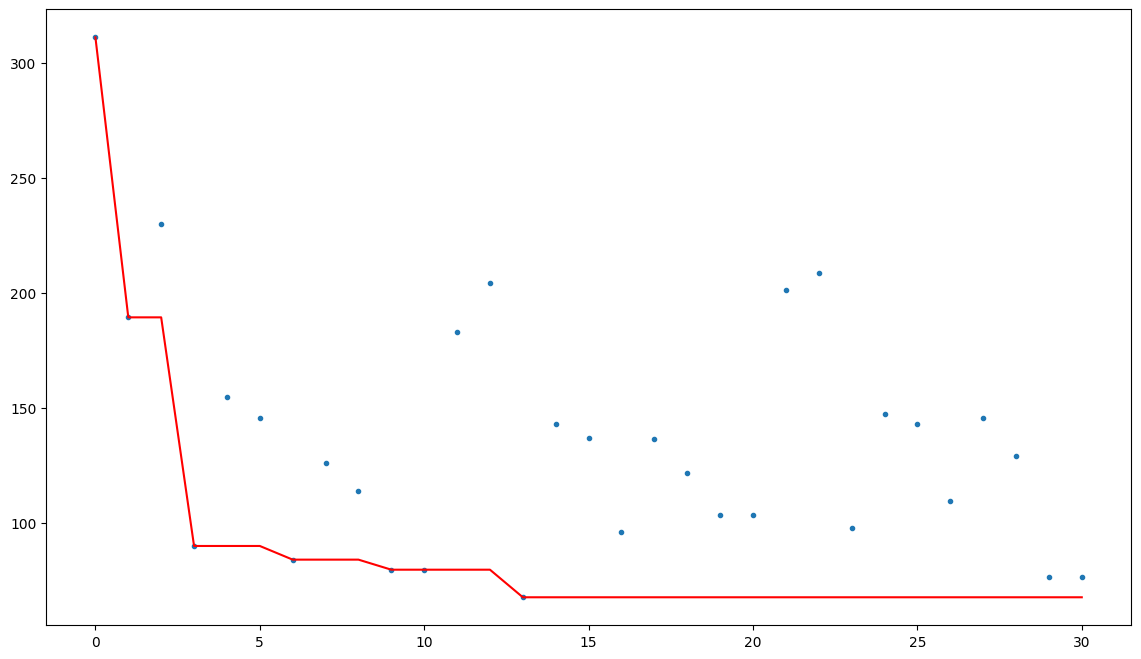

In [798]:
current_solution = solution[:]

max_steps=UNIVERSE_SIZE//10

n_restart=3
ic( current_solution)
#while  valid(current_solution)==False or steps<max_steps:

#current_fit=fitness(current_solution)
#tcost=timeit.timeit(lambda: cost(current_solution), number=100000)
#tfittweak=timeit.timeit(lambda: tweak(current_solution), number=100000)

#tevalu=timeit.timeit(lambda: fitness(current_solution), number=10)
#tevalid=timeit.timeit(lambda: valid(current_solution), number=1000)
#tevalid2=timeit.timeit(lambda: valid2(current_solution), number=1000)
#ic(tcost,tfittweak,tevalu,tevalid,tevalid2)

history = []
dim_step_out=100

for nres in tqdm(range(n_restart)):
    i=0
    current_solution = rng.random(NUM_SETS) < ((1+nres)*(100/n_restart))
    current_fit=fitness2(current_solution)
    if(nres==0):
        defsol=current_solution[:]
        defit=fitness2(defsol)
        history.append(cost(defsol))



    for step in range(max_steps):
        i+=1

        
        
        if(i%(3*max_steps//10)==0):
            #for  j in tqdm(range(10)):
            solution = tweak6(solution,dim_step_out)
            
            i=0
            current_solution=solution[:]
            current_fit=fitness2(solution)
        else:
            solution = tweak5(current_solution,step,max_steps)
        #ic( current_solution,solution)
        sol_fit=fitness2(solution)

        
        history.append(cost(solution))
        #if sol_fit>current_fit:
        #    print("Arrays are good")
        #else:
        #        print("Arrays are bad")
    
        '''if sol_fit>current_fit :
            current_solution = solution
            current_fit=sol_fit
            i=0
            if sol_fit>defit:
                defsol = solution[:]
                defit=sol_fit
        '''
        if sol_fit[0] and sol_fit[1]>current_fit[1] :
            current_solution = solution
            current_fit=sol_fit
            i=0
            if sol_fit[0] and sol_fit[1]>defit[1]:
                defsol = solution[:]
                defit=sol_fit
               
        

        #if(i>=max_steps/10):
        #    break

            #ic(step, current_solution)
 
costofinale=cost(defsol)
ic(costofinale,valid(defsol))

ic(history.index(costofinale))
nrun=history.index(cost(defsol))//max_steps +1
ic(history.index(cost(defsol)),nrun )

index_true=len(np.where(defsol==True)[0])


plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, min)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")


with open('log.txt', 'a') as file:
    
    file.write(f"{UNIVERSE_SIZE} , {NUM_SETS} , {DENSITY} , {max_steps} , {n_restart} , {costofinale} \n")

#plt.ylim(71443,2414430)